In [1]:
from tqdm.notebook import tqdm
#import network
#import utils
import os
import random
import argparse
import numpy as np

from torch.utils import data
from time import perf_counter
#from datasets import VOCSegmentation, Cityscapes
#from utils import ext_transforms as et
#from metrics import StreamSegMetricsd
import time
import torch
import torch.nn as nn
#from utils.visualizer import Visualizer
from threading import Thread
import IPython

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

import pickle
import zipfile

In [2]:
import torch.nn as nn
import torch.nn.functional as Fun
import torch 

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=0, size_average=True, ignore_index=255):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.size_average = size_average

    def forward(self, inputs, targets):
        ce_loss = Fun.cross_entropy(
            inputs, targets, reduction='none', ignore_index=self.ignore_index)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        if self.size_average:
            return focal_loss.mean()
        else:
            return focal_loss.sum()


import numpy as np
from sklearn.metrics import confusion_matrix

class _StreamMetrics(object):
    def __init__(self):
        """ Overridden by subclasses """
        raise NotImplementedError()

    def update(self, gt, pred):
        """ Overridden by subclasses """
        raise NotImplementedError()

    def get_results(self):
        """ Overridden by subclasses """
        raise NotImplementedError()

    def to_str(self, metrics):
        """ Overridden by subclasses """
        raise NotImplementedError()

    def reset(self):
        """ Overridden by subclasses """
        raise NotImplementedError()      

class StreamSegMetrics(_StreamMetrics):
    """
    Stream Metrics for Semantic Segmentation Task
    """
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def update(self, label_trues, label_preds):
        #boolarr=label_trues==255
        #label_preds[boolarr]=255
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist( lt.flatten(), lp.flatten() )
    
    @staticmethod
    def to_str(results):
        string = "\n"
        for k, v in results.items():
            if k!="Class IoU":
                string += "%s: %f\n"%(k, v)
        
        #string+='Class IoU:\n'
        #for k, v in results['Class IoU'].items():
        #    string += "\tclass %d: %f\n"%(k, v)
        return string

    def _fast_hist(self, label_true, label_pred):
        mask = (label_true >= 0) & (label_true < self.n_classes)
        hist = np.bincount(
            self.n_classes * label_true[mask].astype(int) + label_pred[mask],
            minlength=self.n_classes ** 2,
        ).reshape(self.n_classes, self.n_classes)
        return hist

    def get_results(self):
        """Returns accuracy score evaluation result.
            - overall accuracy
            - mean accuracy
            - mean IU
            - fwavacc
        """
        hist = self.confusion_matrix
        acc = np.diag(hist).sum() / hist.sum()
        acc_cls = np.diag(hist) / hist.sum(axis=1)
        acc_cls = np.nanmean(acc_cls)
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu)
        freq = hist.sum(axis=1) / hist.sum()
        fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
        cls_iu = dict(zip(range(self.n_classes), iu))
#         cls_ac = dict(zip(range(self.n_classes),np.diag(hist)/(hist.sum(axis=1))))

        return {
                "Overall Acc": acc,
                "Mean Acc": acc_cls,
                "FreqW Acc": fwavacc,
                "Mean IoU": mean_iu,
                #"Class Acc": cls_ac,
                "Class IoU": cls_iu,
            }
        
    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))

class AverageMeter(object):
    """Computes average values"""
    def __init__(self):
        self.book = dict()

    def reset_all(self):
        self.book.clear()
    
    def reset(self, id):
        item = self.book.get(id, None)
        if item is not None:
            item[0] = 0
            item[1] = 0

    def update(self, id, val):
        record = self.book.get(id, None)
        if record is None:
            self.book[id] = [val, 1]
        else:
            record[0]+=val
            record[1]+=1

    def get_results(self, id):
        record = self.book.get(id, None)
        assert record is not None
        return record[0] / record[1]


In [3]:
# import numpy as np
# a=np.array([1,3,4,14,1,2,42,2])
# boolarr=a==1
# b=np.array([5,3,4,14,10,2,42,100])
# b[boolarr]=255
# print(b)

In [4]:
_pil_interpolation_to_str = {
    Image.NEAREST: 'PIL.Image.NEAREST',
    Image.BILINEAR: 'PIL.Image.BILINEAR',
    Image.BICUBIC: 'PIL.Image.BICUBIC',
    Image.LANCZOS: 'PIL.Image.LANCZOS',
    Image.HAMMING: 'PIL.Image.HAMMING',
    Image.BOX: 'PIL.Image.BOX',
}
class ExtResize(object):
    """Resize the input PIL Image to the given size.
    Args:
        size (sequence or int): Desired output size. If size is a sequence like
            (h, w), output size will be matched to this. If size is an int,
            smaller edge of the image will be matched to this number.
            i.e, if height > width, then image will be rescaled to
            (size * height / width, size)
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
    """

    def __init__(self, size, interpolation=Image.BILINEAR):
        #assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Image to be scaled.
        Returns:
            PIL Image: Rescaled image.
        """
        return F.resize(img, self.size, self.interpolation), F.resize(lbl, self.size, Image.NEAREST)

    def __repr__(self):
        interpolate_str = _pil_interpolation_to_str[self.interpolation]
        return self.__class__.__name__ + '(size={0}, interpolation={1})'.format(self.size, interpolate_str) 


In [5]:
os.chdir("/kaggle/input/")

In [6]:
!ls

adek20-screen-parsing  coco-dataset	 my-dataset
adk-coco-filter        custom-sidewalk	 script
cityscape-mobilenet    deeplab17classes  version-10


In [7]:
os.chdir("./script/")

In [8]:
!python utils.py
!python mobile_net.py
!python deeplab.py

In [9]:
from utils import *
from mobile_net import *
from deeplab import DeepLabHeadV3Plus
from deeplab import IntermediateLayerGetter
from deeplab import DeepLabV3

In [10]:
!ls
os.chdir("..")
os.chdir('../working')

deeplab.py  mobile_net.py  resnet.py  utils.py


In [11]:
#Model Starts from this layer

def _segm_mobilenet(name, backbone_name, num_classes, output_stride, pretrained_backbone):
    if output_stride==8:
        aspp_dilate = [12, 24, 36]
    else:
        aspp_dilate = [6, 12, 18]

    backbone = mobilenet_v2(pretrained=pretrained_backbone, output_stride=output_stride)
    
    # rename layers
    backbone.low_level_features = backbone.features[0:4]
    backbone.high_level_features = backbone.features[4:-1]
    backbone.features = None
    backbone.classifier = None

    inplanes = 320
    low_level_planes = 24
    
    if name=='deeplabv3plus':
        return_layers = {'high_level_features': 'out', 'low_level_features': 'low_level'}
        classifier = DeepLabHeadV3Plus(inplanes, low_level_planes, num_classes, aspp_dilate)
    elif name=='deeplabv3':
        return_layers = {'high_level_features': 'out'}
        classifier = DeepLabHead(inplanes , num_classes, aspp_dilate)
    backbone = IntermediateLayerGetter(backbone, return_layers=return_layers)

    model = DeepLabV3(backbone, classifier)
    return model

def _load_model(arch_type, backbone, num_classes, output_stride, pretrained_backbone):

    if backbone=='mobilenetv2':
        model = _segm_mobilenet(arch_type, backbone, num_classes, output_stride=output_stride, pretrained_backbone=pretrained_backbone)
    else:
        raise NotImplementedError
    return model

def deeplabv3_mobilenet(num_classes=21, output_stride=8, pretrained_backbone=True, **kwargs):
    """Constructs a DeepLabV3 model with a MobileNetv2 backbone.
    Args:
        num_classes (int): number of classes.
        output_stride (int): output stride for deeplab.
        pretrained_backbone (bool): If True, use the pretrained backbone.
    """
    return _load_model('deeplabv3', 'mobilenetv2', num_classes, output_stride=output_stride, pretrained_backbone=pretrained_backbone)

def deeplabv3plus_mobilenet(num_classes=21, output_stride=8, pretrained_backbone=True):
    """Constructs a DeepLabV3+ model with a MobileNetv2 backbone.
    Args:
        num_classes (int): number of classes.
        output_stride (int): output stride for deeplab.
        pretrained_backbone (bool): If True, use the pretrained backbone.
    """
    return _load_model('deeplabv3plus', 'mobilenetv2', num_classes, output_stride=output_stride, pretrained_backbone=pretrained_backbone)


In [12]:
import json
import os
from collections import namedtuple

import torch
import torch.utils.data as data
from PIL import Image
import numpy as np


class CustomData(data.Dataset):

    # Based on https://github.com/mcordts/cityscapesScripts
    colorMap={
        "backgroud": (225,229 , 204),
        'wall':(152, 152, 79),
        'building':(70, 70, 70),
        'sky':(70, 130, 180),
        'sidewalk':(244, 35, 232),
        'field/grass':(152, 251, 152),
        'vegitation':(107, 142, 35),
        'person': (220, 20, 60),
        'mountain':(139, 218, 51),
        'stairs':(202, 251, 254),
        'bench':(108, 246, 107),
        'pole':(153, 153, 153),
        'car':(41, 34, 177),
        'bike':(111, 34, 177),
        'animal':(211, 205, 33),
        'ground':(147, 147, 136),
        'fence':(241, 170, 17),
        'water':(29, 231, 229),
        'road':(35, 18, 16),
        'sign_board':(113, 97, 41),
        'floor':(73, 23, 77),
        'traffic_light':(225, 175, 57),
        'ceeling':(51, 0, 0),
        'unlabelled':(0,0,0),
        
    }
     
    # Based on https://github.com/mcordts/cityscapesScripts
    CustomDataSet = namedtuple('CustomDataSet', ['name', 'id', 'train_id', 'category', 'category_id',
                                                     'has_instances', 'ignore_in_eval', 'color'])
    classes = [
            CustomDataSet('backgroud',       0, 0, 'obstacle', 0, False, True, colorMap['backgroud']),
            CustomDataSet('wall',            1, 1, 'solid', 0, False, True, colorMap['wall']),
            CustomDataSet('building',        2, 2, 'solid', 0, False, True, colorMap['building']),
            CustomDataSet('sky',             3, 3, 'backgroud', 0, False, True, colorMap['sky']),
            CustomDataSet('sidewalk',        4, 4, 'nature', 0, False, True, colorMap['sidewalk']),
            CustomDataSet('field/grass',     5, 5, 'nature', 0, False, True, colorMap['field/grass']),
            CustomDataSet('vegitation',      6, 6, 'nature', 0, False, True, colorMap['vegitation']),
            CustomDataSet('person',          7, 7, 'human', 0, False, True, colorMap['person']),
            CustomDataSet('mountain',        8, 8, 'nature', 0, False, True, colorMap['mountain']),
            CustomDataSet('stairs',          9, 255, 'solid', 0, False, True, colorMap['stairs']),
            CustomDataSet('bench',           10, 0, 'obstacle', 0, False, True, colorMap['bench']),
            CustomDataSet('pole',            11, 0, 'obstacle', 0, False, True, colorMap['pole']),
            CustomDataSet('car',             12, 9, 'vahicle', 0, False, True, colorMap['car']),
            CustomDataSet('bike',            13, 10, 'vahicle', 0, False, True, colorMap['bike']),
            CustomDataSet('animal',          14, 11, 'animal', 0, False, True, colorMap['animal']),
            CustomDataSet('ground',          15, 12, 'land', 0, False, True, colorMap['ground']),
            CustomDataSet('fence',           16, 13, 'solid', 0, False, True, colorMap['fence']),
            CustomDataSet('water',           17, 14, 'land', 0, False, True, colorMap['water']),
            CustomDataSet('road',            18, 15, 'land', 0, False, True, colorMap['road']),
            CustomDataSet('sign_board',      19, 0, 'obstacle', 0, False, True, colorMap['sign_board']),
            CustomDataSet('floor',           20, 4, 'land', 0, False, True, colorMap['floor']),
            CustomDataSet('traffic_light',   21, 0,'obstacle', 0, False, True, colorMap['traffic_light']),
            CustomDataSet('ceeling',         22, 16, 'ceeling', 0, False, True, colorMap['ceeling']),
            CustomDataSet('unlabelled',      23, 255, 'void', 0, False, True, colorMap['unlabelled']),
            
    ]
    
    train_id_to_color = [c.color for c in classes if (c.train_id != -1 and c.train_id != 255)]
    id_to_color = [c.color for c in classes]
    train_id_to_color.append([0, 0, 0])
    train_id_to_color = np.array(train_id_to_color)
    train_id_to_label= [c.name for c in classes if (c.train_id != -1 and c.train_id != 255)]
    train_id_to_label.append("unlabeled")
    train_id_to_label = np.array(train_id_to_label)
    id_to_train_id = np.array([c.train_id for c in classes])
    
    def __init__(self, root_image, root_target, split='train', mode='fine', target_type='semantic', transform=None):        
        
        self.root_image = [os.path.expanduser(i) for i in root_image ]
        self.root_target = [os.path.expanduser(i) for i in root_target]
        
        self.images = []
        self.targets = []
        self.transform = transform
        self.split = split
        
        for i in range(len(self.root_image)):
            self.root_image[i]=os.path.join(self.root_image[i],split)
            self.root_target[i]=os.path.join(self.root_target[i],split)
            print(self.root_image[i])
            print(self.root_target[i])

            lst=os.listdir(self.root_target[i])
            
            for img in lst:
                if img[0]=="C":
                    self.images.append(os.path.join(root_image[i],img[:-4]+'.jpg'))
                else:
                    self.images.append(os.path.join(self.root_image[i],img[:-4]+'.jpg'))
                self.targets.append(os.path.join(self.root_target[i],img))
        print(len(self.images))
        print(len(self.targets))


    @classmethod
    def encode_target(cls, target):
        return cls.id_to_train_id[np.array(target)]

    @classmethod
    def decode_target(cls, target):
        target[target == 255] = 0
        #target = target.astype('uint8') + 1
        return cls.train_id_to_color[target]

    def __getitem__(self, index):
        image = Image.open(self.images[index]).convert('RGB')
        target = Image.open(self.targets[index])
        
       
        if self.transform:
            image, target = self.transform(image, target)
        target = self.encode_target(target)
        #print(image.shape)
        #print(target.shape)
        
        return image, target

    def __len__(self):
        return len(self.images)

In [13]:
from torchvision.transforms.functional import normalize
import torch.nn as nn
import numpy as np
import os 

def denormalize(tensor, mean, std):
    mean = np.array(mean)
    std = np.array(std)

    _mean = -mean/std
    _std = 1/std
    return normalize(tensor, _mean, _std)

class Denormalize(object):
    def __init__(self, mean, std):
        mean = np.array(mean)
        std = np.array(std)
        self._mean = -mean/std
        self._std = 1/std

    def __call__(self, tensor):
        if isinstance(tensor, np.ndarray):
            return (tensor - self._mean.reshape(-1,1,1)) / self._std.reshape(-1,1,1)
        return normalize(tensor, self._mean, self._std)

def set_bn_momentum(model, momentum=0.1):
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.momentum = momentum

def fix_bn(model):
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()

def mkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [14]:
from matplotlib import gridspec

def create_label_colormap():
    colormap = CustomData.train_id_to_color
    return colormap


def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(20, 4))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image =  CustomData.decode_target(output_predictions.cpu()).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    print("Uniques Labels Found",unique_labels)
    ax = plt.subplot(grid_spec[3])
    
    
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


LABEL_NAMES = CustomData.train_id_to_label

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [15]:
class opts:
    dataset="cityscapes"
    crop_size=512
    data_root="../input/coco-dataset/Coco Stuff Dataset/imageLists"
  
    imageFolder= [
                  '../input/adek20-screen-parsing/ADEChallengeData2016/images',
                  '../input/adek20-screen-parsing/ADEChallengeData2016/images',
                  '../input/coco-dataset/Coco Stuff Dataset/images',
                  '../input/custom-sidewalk/custom_sidewalk_updated/customdataset',
                 ]
    
    targetFolder=[
        '../input/adk-coco-filter/ADK_COCO_Filter_Anotation_Updated/adk',
                  '../input/adk-coco-filter/ADK_COCO_Filter_Anotation_Updated/adk_floor_filter',
                  '../input/adk-coco-filter/ADK_COCO_Filter_Anotation_Updated/coco',
                  '../input/custom-sidewalk/custom_sidewalk_updated/customannotations',
                 ]
    lr=0.00001
    weight_decay=0.0001
    lr_policy= 'poly'  #learning rate scheduler policy
    step_size=10000
    saved_path="../input/version-10/Files/"
    pretrained=True
    continue_training=True   #train previous model
    batch_size=16
    val_batch_size=16
    num_classes=17
    loss_function="focal" #"cross_entropy

<!-- ### import numpy as np
# from sklearn.metrics import confusion_matrix

# class _StreamMetrics(object):
#     def __init__(self):
#         """ Overridden by subclasses """
#         raise NotImplementedError()

#     def update(self, gt, pred):
#         """ Overridden by subclasses """
#         raise NotImplementedError()

#     def get_results(self):
#         """ Overridden by subclasses """
#         raise NotImplementedError()

#     def to_str(self, metrics):
#         """ Overridden by subclasses """
#         raise NotImplementedError()

#     def reset(self):
#         """ Overridden by subclasses """
#         raise NotImplementedError()      

# class StreamSegMetrics(_StreamMetrics):
#     """
#     Stream Metrics for Semantic Segmentation Task
#     """
#     def __init__(self, n_classes):
#         self.n_classes = n_classes
#         self.confusion_matrix = np.zeros((n_classes, n_classes))

#     def update(self, label_trues, label_preds):
#         for lt, lp in zip(label_trues, label_preds):
#             self.confusion_matrix += self._fast_hist( lt.flatten(), lp.flatten() )
    
#     @staticmethod
#     def to_str(results):
#         string = "\n"
#         for k, v in results.items():
#             if k!="Class IoU":
#                 string += "%s: %f\n"%(k, v)
        
#         #string+='Class IoU:\n'
#         #for k, v in results['Class IoU'].items():
#         #    string += "\tclass %d: %f\n"%(k, v)
#         return string

#     def _fast_hist(self, label_true, label_pred):
#         mask = (label_true >= 0) & (label_true < self.n_classes)
#         hist = np.bincount(
#             self.n_classes * label_true[mask].astype(int) + label_pred[mask],
#             minlength=self.n_classes ** 2,
#         ).reshape(self.n_classes, self.n_classes)
#         return hist

#     def get_results(self):
#         """Returns accuracy score evaluation result.
#             - overall accuracy
#             - mean accuracy
#             - mean IU
#             - fwavacc
#         """
#         hist = self.confusion_matrix
#         acc = np.diag(hist).sum() / hist.sum()
#         acc_cls = np.diag(hist) / hist.sum(axis=1)
#         acc_cls = np.nanmean(acc_cls)
#         iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
#         mean_iu = np.nanmean(iu)
#         freq = hist.sum(axis=1) / hist.sum()
#         fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
#         cls_iu = dict(zip(range(self.n_classes), iu))

#         return {
#                 "Overall Acc": acc,
#                 "Mean Acc": acc_cls,
#                 "FreqW Acc": fwavacc,
#                 "Mean IoU": mean_iu,
#                 "Class IoU": cls_iu,
#             }
        
#     def reset(self):
#         self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))

# class AverageMeter(object):
#     """Computes average values"""
#     def __init__(self):
#         self.book = dict()

#     def reset_all(self):
#         self.book.clear()
    
#     def reset(self, id):
#         item = self.book.get(id, None)
#         if item is not None:
#             item[0] = 0
#             item[1] = 0

#     def update(self, id, val):
#         record = self.book.get(id, None)
#         if record is None:
#             self.book[id] = [val, 1]
#         else:
#             record[0]+=val
#             record[1]+=1

#     def get_results(self, id):
#         record = self.book.get(id, None)
#         assert record is not None
#         return record[0] / record[1] -->

In [16]:

def get_dataset(opts):
    """ Dataset And Augmentation
    """
    if opts.dataset == 'cityscapes':
        train_transform = ExtCompose([
            #et.ExtResize( 512 ),
            ExtResize((400,400)),
            #ExtRandomCrop(size=(opts.crop_size, opts.crop_size),pad_if_needed=True),
            ExtColorJitter( brightness=0.5, contrast=0.5, saturation=0.5 ),
            ExtRandomHorizontalFlip(),
            ExtToTensor(),
            ExtNormalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
        ])
        val_transform = ExtCompose([
            #et.ExtResize( 512 ),
            ExtResize((400,400)),
            #ExtRandomCrop(size=(opts.crop_size, opts.crop_size)),
            ExtToTensor(),
            ExtNormalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
        ])

        train_dst = CustomData(root_image=opts.imageFolder,root_target=opts.targetFolder,
                               split='training', transform=train_transform)
        val_dst = CustomData(root_image=opts.imageFolder,root_target=opts.targetFolder,
                             split='validation', transform=val_transform)
    return train_dst, val_dst

In [17]:
train_dst, val_dst = get_dataset(opts)
train_loader = data.DataLoader(train_dst, batch_size=opts.batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = data.DataLoader(val_dst, batch_size=opts.val_batch_size, shuffle=True, num_workers=4)
print("Dataset: %s, Train set: %d, Val set: %d" % (opts.dataset, len(train_dst), len(val_dst)))

../input/adek20-screen-parsing/ADEChallengeData2016/images/training
../input/adk-coco-filter/ADK_COCO_Filter_Anotation_Updated/adk/training
../input/adek20-screen-parsing/ADEChallengeData2016/images/training
../input/adk-coco-filter/ADK_COCO_Filter_Anotation_Updated/adk_floor_filter/training
../input/coco-dataset/Coco Stuff Dataset/images/training
../input/adk-coco-filter/ADK_COCO_Filter_Anotation_Updated/coco/training
../input/custom-sidewalk/custom_sidewalk_updated/customdataset/training
../input/custom-sidewalk/custom_sidewalk_updated/customannotations/training
15108
15108
../input/adek20-screen-parsing/ADEChallengeData2016/images/validation
../input/adk-coco-filter/ADK_COCO_Filter_Anotation_Updated/adk/validation
../input/adek20-screen-parsing/ADEChallengeData2016/images/validation
../input/adk-coco-filter/ADK_COCO_Filter_Anotation_Updated/adk_floor_filter/validation
../input/coco-dataset/Coco Stuff Dataset/images/validation
../input/adk-coco-filter/ADK_COCO_Filter_Anotation_Update

In [18]:
dataset_iter = iter(train_loader)
img,lal=dataset_iter.next()

In [19]:
# import cv2
# dim=img.shape
# plt.imshow(np.transpose(img[0], (1, 2, 0)))
# cv2.waitKey(0)
# plt.imshow(img[0].reshape(img[0].shape[1],img[0].shape[2],img[0].shape[0]))

In [20]:
# #plt.imshow(lal[0], cmap="gray") 
# plt.imshow(CustomData.decode_target(lal[0]))

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: %s" % device)

Device: cuda


In [22]:
model = deeplabv3plus_mobilenet(num_classes=19, output_stride=8)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [23]:
print(model)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (low_level_features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

In [24]:
def dfs_freeze(model):
    for name, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = False
        dfs_freeze(child)

In [25]:
#dfs_freeze(model.backbone)

In [26]:
optimizer = torch.optim.SGD(params=[
            {'params': model.backbone.parameters(), 'lr': 0.1*opts.lr},
            {'params': model.classifier.parameters(), 'lr': opts.lr},
        ], lr=opts.lr, momentum=0.9, weight_decay=opts.weight_decay)
metrics = StreamSegMetrics(opts.num_classes)

In [27]:
def save_ckpt(path):
    """ save current model
    """
    torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "best_score": best_score,
    }, path)
    print("Model saved as %s" % path)

In [28]:
creterion=""
if opts.loss_function=="focal":
    criterion = FocalLoss(ignore_index=255, size_average=True)
else:
    criterion = nn.CrossEntropyLoss(ignore_index=255, reduction='mean')
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=opts.step_size, gamma=0.1)

In [29]:

#criterion.to(device)

cur_epoch=0
best_score=0
Loss=[]
Score=[]

if opts.pretrained:
    model.classifier.classifier[3]=nn.Conv2d(256, opts.num_classes, kernel_size=(1, 1), stride=(1, 1)) 
#     model.classifier.classifier[3]=nn.Conv2d(256, opts.num_classes, kernel_size=(1, 1), stride=(1, 1))    

#     model.classifier.classifier[3]=nn.Conv2d(256, opts.num_classes, kernel_size=(1, 1), stride=(1, 1))    

#     checkpoint=torch.load('../input/cityscape-mobilenet/best_deeplabv3plus_mobilenet_cityscapes_os16.pth',map_location=torch.device('cpu'))
#     model.load_state_dict(checkpoint["model_state"])
    ckpt=opts.saved_path+"last_model.pth"
    checkpoint = torch.load(ckpt, map_location=torch.device('cpu'))
#     checkpoint=torch.load('../input/cityscape-mobilenet/best_deeplabv3plus_mobilenet_cityscapes_os16.pth',map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint["model_state"])
#     model.classifier.classifier[3]=nn.Conv2d(256, opts.num_classes, kernel_size=(1, 1), stride=(1, 1))    

#     model.load_state_dict(checkpoint["model_state"])
#     model.classifier.classifier[3]=nn.Conv2d(256, opts.num_classes, kernel_size=(1, 1), stride=(1, 1)) 
    #model = nn.DataParallel(model)
    model.to(device)
    with open(opts.saved_path+"Loss.txt","rb") as File:
        Loss = pickle.load(File)
    with open(opts.saved_path+"Score.txt","rb") as File:
        Score = pickle.load(File)
        
    if opts.continue_training:
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        scheduler.load_state_dict(checkpoint["scheduler_state"])
        cur_epoch = checkpoint["epoch"]
        best_score = checkpoint['best_score']
        print("Training state restored from %s" % opts.saved_path)
    print("Model restored from %s" % opts.saved_path)
    del checkpoint  # free memory
else:
    #model = torch.nn.DataParallel(model)
    checkpoint=torch.load('../input/cityscape-mobilenet/best_deeplabv3plus_mobilenet_cityscapes_os16.pth',map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint["model_state"])
    #model=model.module
    model.classifier.classifier[3]=nn.Conv2d(256, opts.num_classes, kernel_size=(1, 1), stride=(1, 1))    
    #model.finalConv= nn.Conv2d(48, opts.num_classes, 1, 1, bias=True) 
    #model = nn.DataParallel(model)
    model.to(device)


Training state restored from ../input/version-10/Files/
Model restored from ../input/version-10/Files/


In [30]:
#dfs_freeze(model.backbone)
print(len(Loss))

164


In [31]:
print(len(Score))

164


In [32]:
#print(model)
print(best_score)
print(cur_epoch)
#SummaryName = "./FirstAttempt"

0.4235282524966973
164


In [33]:

def validate1(opts, model,loader,metrics,device):
    
    metrics.reset()
    #validation_loss = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)

            outputs = model(images)
            preds = outputs.detach().max(dim=1)[1].cpu().numpy()
            targets=labels.cpu().numpy()
            #loss = criterion(outputs, labels)
            
            
            metrics.update(targets, preds)
            #np_loss=loss.detach().cpu().numpy() 
            #validation_loss.append(np_loss)
    
    #loss=np.mean(validation_loss)
    #print(validation_loss)
    return metrics.get_results()

In [34]:
print

<function print>

In [35]:
print(cur_epoch)

164


In [36]:
mkdir("./Files")

In [37]:
interval_loss = 0
epochs=cur_epoch+27
max_score=10000000000
model_curve=[]



best_score = 0.0
cur_itrs=0
start = perf_counter()
for epoch in tqdm(range(cur_epoch+1,epochs), desc="Epochs"):
    model.train()
    running_loss = []
    for step, (images, labels) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        cur_itrs += 1
        #print(images.shape)
        #print(labels.shape)
        
        images = images.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.long)
        optimizer.zero_grad()

        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #end = perf_counter()
        
        running_loss.append(loss.item())
        interval_loss += loss.item()
        
    model.eval()
    val_score = validate1(opts=opts, model=model, loader=val_loader, metrics=metrics,device=device)
    print("Training Loss",np.mean(running_loss),"Validation Loss")
    print(metrics.to_str(val_score))

    #if val_score['Mean IoU'] > best_score:  # save best model
    best_score = val_score['Mean IoU']
    save_ckpt('./Files/last_model.pth')
#     else:
#         print("Stopping Condition Occoured")
    Loss.append(np.mean(running_loss))
    Score.append(val_score)
    
    with open("./Files/Loss.txt","wb") as File:
        pickle.dump(Loss,File)
    with open("./Files/Score.txt","wb") as File:
        pickle.dump(Score,File)

    scheduler.step()
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))
end = perf_counter()
print("Time",end-start)

Training Loss 0.9635442697812641 Validation Loss

Overall Acc: 0.754307
Mean Acc: 0.544654
FreqW Acc: 0.609805
Mean IoU: 0.422629

Model saved as ./Files/last_model.pth
Epoch: 166/191 - Loss: 0.9635


Training Loss 0.9602436859140951 Validation Loss

Overall Acc: 0.752142
Mean Acc: 0.548286
FreqW Acc: 0.608449
Mean IoU: 0.423075

Model saved as ./Files/last_model.pth
Epoch: 167/191 - Loss: 0.9602


Training Loss 0.9611542181363182 Validation Loss

Overall Acc: 0.752624
Mean Acc: 0.542917
FreqW Acc: 0.607859
Mean IoU: 0.422207

Model saved as ./Files/last_model.pth
Epoch: 168/191 - Loss: 0.9612


Training Loss 0.9622881456657693 Validation Loss

Overall Acc: 0.755289
Mean Acc: 0.549266
FreqW Acc: 0.610184
Mean IoU: 0.426879

Model saved as ./Files/last_model.pth
Epoch: 169/191 - Loss: 0.9623


Training Loss 0.9593575628976974 Validation Loss

Overall Acc: 0.755593
Mean Acc: 0.552099
FreqW Acc: 0.614663
Mean IoU: 0.424522

Model saved as ./Files/last_model.pth
Epoch: 170/191 - Loss: 0.9594


Training Loss 0.9555738372777505 Validation Loss

Overall Acc: 0.756505
Mean Acc: 0.550995
FreqW Acc: 0.613333
Mean IoU: 0.427153

Model saved as ./Files/last_model.pth
Epoch: 171/191 - Loss: 0.9556


Training Loss 0.9565971609145876 Validation Loss

Overall Acc: 0.755849
Mean Acc: 0.550611
FreqW Acc: 0.614763
Mean IoU: 0.428211

Model saved as ./Files/last_model.pth
Epoch: 172/191 - Loss: 0.9566


Training Loss 0.9566411295895854 Validation Loss

Overall Acc: 0.755969
Mean Acc: 0.552245
FreqW Acc: 0.614353
Mean IoU: 0.428291

Model saved as ./Files/last_model.pth
Epoch: 173/191 - Loss: 0.9566


Training Loss 0.9529654611355414 Validation Loss

Overall Acc: 0.755612
Mean Acc: 0.550929
FreqW Acc: 0.611829
Mean IoU: 0.430818

Model saved as ./Files/last_model.pth
Epoch: 174/191 - Loss: 0.9530


Training Loss 0.9529264183271499 Validation Loss

Overall Acc: 0.757156
Mean Acc: 0.553129
FreqW Acc: 0.614451
Mean IoU: 0.429425

Model saved as ./Files/last_model.pth
Epoch: 175/191 - Loss: 0.9529


Training Loss 0.9515739495161349 Validation Loss

Overall Acc: 0.756086
Mean Acc: 0.550634
FreqW Acc: 0.612638
Mean IoU: 0.430624

Model saved as ./Files/last_model.pth
Epoch: 176/191 - Loss: 0.9516


Training Loss 0.949715172046076 Validation Loss

Overall Acc: 0.757454
Mean Acc: 0.552396
FreqW Acc: 0.613832
Mean IoU: 0.432440

Model saved as ./Files/last_model.pth
Epoch: 177/191 - Loss: 0.9497


Training Loss 0.9464579924704537 Validation Loss

Overall Acc: 0.756872
Mean Acc: 0.554627
FreqW Acc: 0.613004
Mean IoU: 0.433802

Model saved as ./Files/last_model.pth
Epoch: 178/191 - Loss: 0.9465


Training Loss 0.9463973822417082 Validation Loss

Overall Acc: 0.757995
Mean Acc: 0.552233
FreqW Acc: 0.614635
Mean IoU: 0.434649

Model saved as ./Files/last_model.pth
Epoch: 179/191 - Loss: 0.9464


Training Loss 0.9446681712039564 Validation Loss

Overall Acc: 0.758251
Mean Acc: 0.562756
FreqW Acc: 0.617077
Mean IoU: 0.435026

Model saved as ./Files/last_model.pth
Epoch: 180/191 - Loss: 0.9447


Training Loss 0.9448870963520474 Validation Loss

Overall Acc: 0.758067
Mean Acc: 0.555399
FreqW Acc: 0.614263
Mean IoU: 0.438182

Model saved as ./Files/last_model.pth
Epoch: 181/191 - Loss: 0.9449


Training Loss 0.9434389531927765 Validation Loss

Overall Acc: 0.759483
Mean Acc: 0.560490
FreqW Acc: 0.617619
Mean IoU: 0.438080

Model saved as ./Files/last_model.pth
Epoch: 182/191 - Loss: 0.9434


Training Loss 0.9441334337784499 Validation Loss

Overall Acc: 0.759887
Mean Acc: 0.565983
FreqW Acc: 0.619049
Mean IoU: 0.441342

Model saved as ./Files/last_model.pth
Epoch: 183/191 - Loss: 0.9441


Training Loss 0.9397991135006859 Validation Loss

Overall Acc: 0.761294
Mean Acc: 0.566571
FreqW Acc: 0.621466
Mean IoU: 0.441793

Model saved as ./Files/last_model.pth
Epoch: 184/191 - Loss: 0.9398


Training Loss 0.9388867715048411 Validation Loss

Overall Acc: 0.760547
Mean Acc: 0.565571
FreqW Acc: 0.620839
Mean IoU: 0.438985

Model saved as ./Files/last_model.pth
Epoch: 185/191 - Loss: 0.9389


Training Loss 0.938660079020041 Validation Loss

Overall Acc: 0.760977
Mean Acc: 0.566607
FreqW Acc: 0.621744
Mean IoU: 0.443383

Model saved as ./Files/last_model.pth
Epoch: 186/191 - Loss: 0.9387


Training Loss 0.9380582137713357 Validation Loss

Overall Acc: 0.762772
Mean Acc: 0.567526
FreqW Acc: 0.624352
Mean IoU: 0.444038

Model saved as ./Files/last_model.pth
Epoch: 187/191 - Loss: 0.9381


Training Loss 0.9365877917834691 Validation Loss

Overall Acc: 0.759037
Mean Acc: 0.569575
FreqW Acc: 0.619936
Mean IoU: 0.439985

Model saved as ./Files/last_model.pth
Epoch: 188/191 - Loss: 0.9366


Training Loss 0.9328598491098515 Validation Loss

Overall Acc: 0.762461
Mean Acc: 0.571756
FreqW Acc: 0.624392
Mean IoU: 0.444519

Model saved as ./Files/last_model.pth
Epoch: 189/191 - Loss: 0.9329


Training Loss 0.9343499485147062 Validation Loss

Overall Acc: 0.758411
Mean Acc: 0.562137
FreqW Acc: 0.613661
Mean IoU: 0.443151

Model saved as ./Files/last_model.pth
Epoch: 190/191 - Loss: 0.9343


Training Loss 0.9288646942093259 Validation Loss

Overall Acc: 0.762615
Mean Acc: 0.569538
FreqW Acc: 0.623264
Mean IoU: 0.446071

Model saved as ./Files/last_model.pth
Epoch: 191/191 - Loss: 0.9289

Time 29241.63353052


In [38]:
# model.eval()
# val_score = validate1(opts=opts, model=model, loader=val_loader, metrics=metrics,device=device)

In [39]:
# print(Score[-1])

In [40]:
# print(val_score)

In [41]:
# print(val_score)

In [42]:
# print(val_score)

In [43]:
# def zipdir(path, ziph):
#     for root, dirs, files in os.walk(path):
#         for file in files:
#             ziph.write(os.path.join(root, file))

In [44]:
# zipf = zipfile.ZipFile("./Files.zip", 'w', zipfile.ZIP_DEFLATED)
# zipdir('./Files', zipf)
# zipf.close()

In [45]:
from PIL import Image
from torchvision import transforms

from PIL import Image
import requests

In [46]:
#start1 = perf_counter()
input_image = Image.open("../input/adek20-screen-parsing/ADEChallengeData2016/images/validation/ADE_val_00001902.jpg")
#url="https://images.squarespace-cdn.com/content/v1/5c9b3ac2e5f7d1493cede23f/1554710179935-T2AY655VMKGCZ6V5D0AE/ke17ZwdGBToddI8pDm48kBqZKGEd5IotpaYmRYDAsV97gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z5QPOohDIaIeljMHgDF5CVlOqpeNLcJ80NK65_fV7S1UYXHvO3AlG5qAFDx5BBWbEnTecsx1VxL9XkiyXErq2cftN_KfIuurh-w-x7bjNuMJA/london-citizen-m-stairs-15.jpg"
#input_image=Image.open(requests.get(url, stream=True).raw)
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor= preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

model.eval()
with torch.no_grad():
    start = perf_counter()
    output = model(input_batch)[0]
    end = perf_counter()
    print(end-start)

output_predictions = output.argmax(0)
pred = CustomData.decode_target(output_predictions.cpu()).astype(np.uint8)

0.014810479999141535


Uniques Labels Found [ 0  1  2  3  4  5  6  8  9 12 14 15 16]


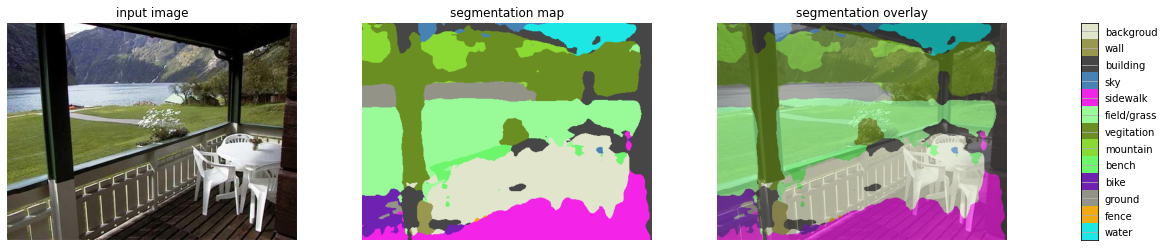

In [47]:
vis_segmentation(input_image, output_predictions.cpu())

In [48]:
# preprocess = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])
# def run_model(input_image):
#     input_tensor= preprocess(input_image)
#     input_batch = input_tensor.unsqueeze(0) 
#     if torch.cuda.is_available():
#         input_batch = input_batch.to('cuda')
#         model.to('cuda')
#     model.eval()
#     with torch.no_grad():
#         output = model(input_batch)[0]
#     output_predictions = output.argmax(0)
#     return output_predictions

In [49]:
# import cv2
# import urllib
# import IPython
# from io import BytesIO
# import matplotlib.pyplot as plt
# import io
# import pickle

# np_buff=[]

# def vis_segmentation_stream(image, seg_map, index):
    
#     """Visualizes segmentation overlay view and stream it with IPython display."""
# #     fig=plt.figure(figsize=(12, 7))
#     seg_image = CustomData.decode_target(seg_map.cpu()).astype(np.uint8)
#     seg_image=Image.fromarray(seg_image.astype('uint8'), 'RGB')
#     background = image.convert("RGBA")
#     overlay = seg_image.convert("RGBA")

#     new_img = Image.blend(background, overlay, 0.7)
#     #new_img.save("new.png","PNG")
#     img=np.array(new_img)
#     #print(img.shape)
#     np_buff.append(img)


   
# def run_visualization_video(frame, index):
#     """Inferences DeepLab model on a video file and stream the visualization."""
#     original_im = Image.fromarray(frame[..., ::-1])
#     seg_map = run_model(original_im)
#     vis_segmentation_stream(original_im, seg_map, index)


# SAMPLE_VIDEO = '../input/video-test/xyz.mp4'
# if not os.path.isfile(SAMPLE_VIDEO): 
#     print('downloading the sample video...')
#     SAMPLE_VIDEO = urllib.request.urlretrieve('https://github.com/lexfridman/mit-deep-learning/raw/master/tutorial_driving_scene_segmentation/mit_driveseg_sample.mp4')[0]
# print('running deeplab on the sample video...')

# video = cv2.VideoCapture(SAMPLE_VIDEO)
# #print(len(video))

# # # num_frames = 598  # uncomment to use the full sample video
# num_frames = 20000

# try:
#     start = perf_counter()
#     for i in range(num_frames):
#         _, frame = video.read()
#         if not _: break
#         if i%15==0:
#             run_visualization_video(frame, i)
#     end = perf_counter()
#     sec=end-start
#     print(sec/60)
# except KeyboardInterrupt:
#     plt.close()
#     print("Stream stopped.")

In [50]:
# video=cv2.VideoWriter("result.avi",cv2.VideoWriter_fourcc(*'DIVX'), 2,(np_buff[0].shape[1],np_buff[0].shape[0]))
# for i in np_buff:
#     i=i[:,:,:-1]
#     video.write(i[:,:,::-1])
# video.release()

In [51]:
# val_files= os.listdir('../input/floor-separated/Annotation_adk_coco_only/adk/validation')

In [52]:
# len(val_files)

In [53]:
# import cv2
# import urllib
# import IPython
# from io import BytesIO
# import matplotlib.pyplot as plt
# import io
# import pickle
# img_buff=[]
# for valImg in val_files:
#     img=Image.open(os.path.join('../input/adek20-screen-parsing/ADEChallengeData2016/images/validation',valImg[:-4]+'.jpg'))
#     seg_map=run_model(img)
#     pred=CustomData.decode_target(seg_map.cpu()).astype(np.uint8)
#     cv2.imwrite(os.path.join('' , 'waka.jpg'), img)
# #     lab=np.array(Image.open(os.path.join('../input/floor-separated/Annotation_adk_coco_only/adk/validation',valImg)))
# #     lab=CustomData.encode_target(lab)
# #     lab=CustomData.decode_target(lab)
# #     print(pred.shape)
# #     print(lab.shape)
# #     img=np.array(img)
# #     final=np.concatenate((img,pred),axis=1)
# #    print(final.shape)
# #     img_buff.append(final)

In [54]:
# np_buff=np.array(img_buff)

In [55]:
# print(np_buff[1])

In [56]:
# video=cv2.VideoWriter("result1.avi",cv2.VideoWriter_fourcc(*'DIVX'), 2,(np_buff[0].shape[1],np_buff[0].shape[0]))
# for i in np_buff:
#     video.write(i[:,:,::-1])
# video.release()

In [57]:
# def training(opts,model,loader,metrics,device,optimizer):
#     model.train()
#     metrics.reset()
#     running_loss = []
#     for step, (images, labels) in enumerate(tqdm(loader, desc="Training", leave=False)):
#         images = images.to(device, dtype=torch.float32)
#         labels = labels.to(device, dtype=torch.long)
#         optimizer.zero_grad()

#         outputs = model(images)
        
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss.append(loss.item())
        
#         targets=labels.cpu().numpy()
#         preds = outputs.detach().max(dim=1)[1].cpu().numpy()
        
#         metrics.update(targets, preds)
        
#     train_loss=np.mean(running_loss)
#     train_results=metrics.get_results()
#     return train_loss, train_results , model, optimizer
        

# def validate1(opts, model,loader,metrics,device):
#     model.eval()
#     metrics.reset()
#     validation_loss = []
#     with torch.no_grad():
#         for step, (images, labels) in enumerate(loader):
#             images = images.to(device, dtype=torch.float32)
#             labels = labels.to(device, dtype=torch.long)

#             outputs = model(images)
#             preds = outputs.detach().max(dim=1)[1].cpu().numpy()
#             targets=labels.cpu().numpy()
#             loss = criterion(outputs, labels)
            
#             metrics.update(targets, preds)
            
#             np_loss=loss.detach().cpu().numpy() 
#             validation_loss.append(np_loss)
#             if step==10:
#                 break
            
    
#     loss=np.mean(validation_loss)
#     #print(validation_loss)
#     return loss,metrics.get_results()

In [58]:
# writer = SummaryWriter(SummaryName)
# interval_loss = 0
# epochs=20
# max_score=10000000000
# model_curve=[]

# cur_epochs = 0
# best_score = 0.0

# #f = open("demofile2.txt", "w+")
# Loss = []
# Score = []

# for epoch in tqdm(range(epochs), desc="Epochs"):

   
#     train_loss, train_results, model, optimizer=training(opts=opts, model=model, loader=train_loader, metrics=metrics,device=device,optimizer=optimizer)
    
    
#     val_loss, val_results = validate1(opts=opts, model=model, loader=val_loader, metrics=metrics,device=device)
    
#     print("Training Loss",train_loss,"Validation Loss", val_loss)
#     print(metrics.to_str(val_results))

#     if val_results['Mean IoU'] > best_score:  # save best model
#         writer.add_scalars("Loss", {"train": train_loss,"validation": val_loss},epoch)
#         writer.add_scalars("Overall Accuracy", {"train": train_results["Overall Acc"],"validation": val_results["Overall Acc"]},epoch)
#         writer.add_scalars("Mean Accuracy", {"train": train_results["Mean Acc"],"validation": val_results["Mean Acc"]},epoch)
#         writer.add_scalars("FreqW Accuracy", {"train": train_results["FreqW Acc"],"validation": val_results["FreqW Acc"]},epoch)
#         writer.add_scalars("Mean IoU", {"train": train_results["Mean IoU"],"validation": val_results["Mean IoU"]},epoch)
         
#         best_score = val_results['Mean IoU']
#         save_ckpt('./last_model.pth')
        
#     scheduler.step()
#     print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, train_loss))